# The Stock Market Data

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize)

In [2]:
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
    (LinearDiscriminantAnalysis as LDA,
     QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [3]:
Smarket = load_data('Smarket')
Smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [4]:
Smarket.columns

Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')

In [5]:
Smarket.corr(numeric_only=True)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


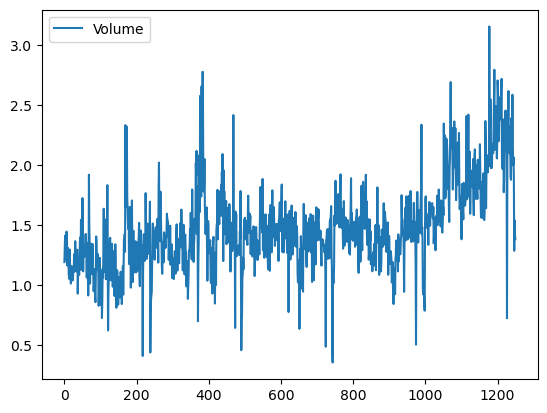

In [6]:
Smarket.plot(y='Volume');

## Logistic Regression

In [7]:
allvars = Smarket.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)
X = design.fit_transform(Smarket)
y = Smarket.Direction == 'Up'
glm = sm.GLM(y,
             X,
             family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-0.1260,0.241,-0.523,0.601
Lag1,-0.0731,0.050,-1.457,0.145
Lag2,-0.0423,0.050,-0.845,0.398
Lag3,0.0111,0.050,0.222,0.824
Lag4,0.0094,0.050,0.187,0.851
Lag5,0.0103,0.050,0.208,0.835
Volume,0.1354,0.158,0.855,0.392


In [8]:
results.params

intercept   -0.126000
Lag1        -0.073074
Lag2        -0.042301
Lag3         0.011085
Lag4         0.009359
Lag5         0.010313
Volume       0.135441
dtype: float64

In [9]:
results.pvalues

intercept    0.600700
Lag1         0.145232
Lag2         0.398352
Lag3         0.824334
Lag4         0.851445
Lag5         0.834998
Volume       0.392404
dtype: float64

In [10]:
probs = results.predict()
probs[:10]

array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

In [11]:
labels = np.array(['Down']*1250)
labels[probs > 0.5] = 'Up'

In [12]:
confusion_table(labels, Smarket.Direction)

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


In [13]:
(507+145)/1250, np.mean(labels == Smarket.Direction)

(0.5216, 0.5216)

In [14]:
Smarket['Year'].value_counts()

2002    252
2003    252
2004    252
2005    252
2001    242
Name: Year, dtype: int64

In [15]:
train = (Smarket.Year < 2005)
Smarket_train = Smarket.loc[train]
Smarket_test = Smarket.loc[~train]
Smarket_test.shape

(252, 9)

In [16]:
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)

In [17]:
D = Smarket.Direction
L_train, L_test = D.loc[train], D.loc[~train]

In [18]:
labels = np.array(['Down']*252)
labels[probs > 0.5] = 'Up'
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


In [19]:
np.mean(labels==L_test), np.mean(labels != L_test)

(0.4801587301587302, 0.5198412698412699)

In [20]:
model = MS(['Lag1', 'Lag2']).fit(Smarket)
X = model.transform(Smarket)
X_train, X_test = X.loc[train], X.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)
labels = np.array(['Down']*252)
labels[probs>0.5] = 'Up'
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [21]:
(35+106)/252, 106/(106+76)

(0.5595238095238095, 0.5824175824175825)

In [22]:
newdata = pd.DataFrame({'Lag1':[1.2, 1.5],
                        'Lag2':[1.1, -0.8]});
newX = model.transform(newdata)
results.predict(newX)

0    0.479146
1    0.496094
dtype: float64

## Linear Discriminant Analysis

In [23]:
lda = LDA(store_covariance=True)

In [24]:
X_train, X_test = [M.drop(columns=['intercept'])
                   for M in [X_train, X_test]]
lda.fit(X_train, L_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [25]:
lda.feature_names_in_

array(['Lag1', 'Lag2'], dtype=object)

In [26]:
lda.classes_

array(['Down', 'Up'], dtype='<U4')

In [27]:
lda.covariance_

array([[ 1.50886781, -0.03340234],
       [-0.03340234,  1.5095363 ]])

In [28]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [29]:
lda.priors_

array([0.49198397, 0.50801603])

In [30]:
lda.scalings_

array([[-0.64201904],
       [-0.51352928]])

In [31]:
lda_pred = lda.predict(X_test)

In [32]:
confusion_table(lda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [33]:
lda_prob = lda.predict_proba(X_test)
np.all(
      np.where(lda_prob[:,1] >= 0.5, 'Up', 'Down') == lda_pred
       )

True

In [34]:
np.all(
    [lda.classes_[i] for i in np.argmax(lda_prob, 1)] ==
        lda_pred
)

True

In [35]:
np.sum(lda_prob[:0] > 0.9)

0

## Quadratic Discriminant Analysis

In [36]:
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [37]:
qda.means_, qda.priors_

(array([[ 0.04279022,  0.03389409],
        [-0.03954635, -0.03132544]]),
 array([0.49198397, 0.50801603]))

In [38]:
qda.covariance_

[array([[ 1.50662277, -0.03924806],
        [-0.03924806,  1.53559498]]),
 array([[ 1.51700576, -0.02787349],
        [-0.02787349,  1.49026815]])]

In [39]:
qda_pred = qda.predict(X_test)
confusion_table(qda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,30,20
Up,81,121


In [40]:
np.mean(qda_pred == L_test)

0.5992063492063492

## Naive Bayes

In [41]:
NB = GaussianNB()
NB.fit(X_train, L_train)

GaussianNB()

In [42]:
NB.classes_

array(['Down', 'Up'], dtype='<U4')

In [43]:
NB.class_prior_

array([0.49198397, 0.50801603])

In [44]:
NB.theta_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [45]:
NB.var_

array([[1.50355429, 1.53246749],
       [1.51401364, 1.48732877]])

In [46]:
X_train[L_train == 'Down'].mean()

Lag1    0.042790
Lag2    0.033894
dtype: float64

In [47]:
X_train[L_train == 'Down'].var(ddof=0)

Lag1    1.503554
Lag2    1.532467
dtype: float64

In [48]:
nb_labels = NB.predict(X_test)
confusion_table(nb_labels, L_test)

Truth,Down,Up
Predicted,,
Down,29,20
Up,82,121


In [49]:
np.mean(nb_labels == L_test)

0.5952380952380952

In [50]:
NB.predict_proba(X_test)[:5]

array([[0.4873288 , 0.5126712 ],
       [0.47623584, 0.52376416],
       [0.46529531, 0.53470469],
       [0.47484469, 0.52515531],
       [0.49020587, 0.50979413]])

## K-Nearest Neighbors

In [51]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred, L_test)

Truth,Down,Up
Predicted,,
Down,43,58
Up,68,83


In [52]:
(83+43)/252, np.mean(knn1_pred == L_test)

(0.5, 0.5)

In [53]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3_pred = knn3.fit(X_train, L_train).predict(X_test)
np.mean(knn3_pred == L_test)

0.5317460317460317

In [54]:
Caravan = load_data('Caravan')
Purchase = Caravan.Purchase
Purchase.value_counts()

No     5474
Yes     348
Name: Purchase, dtype: int64

In [55]:
348 / 5822

0.05977327378907592

In [56]:
feature_df = Caravan.drop(columns=['Purchase'])

In [57]:
scaler = StandardScaler(with_mean=True,
                       with_std=True,
                       copy=True)

In [58]:
scaler.fit(feature_df)
X_std = scaler.transform(feature_df)

In [76]:
feature_std = pd.DataFrame(
                 X_std,
                 columns=feature_df.columns)
feature_std.std()

MOSTYPE     1.000086
MAANTHUI    1.000086
MGEMOMV     1.000086
MGEMLEEF    1.000086
MOSHOOFD    1.000086
              ...   
AZEILPL     1.000086
APLEZIER    1.000086
AFIETS      1.000086
AINBOED     1.000086
ABYSTAND    1.000086
Length: 85, dtype: float64

In [77]:
(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(feature_std,
                            Purchase,
                            test_size=1000,
                            random_state=0)

In [87]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1_pred = knn1.fit(X_train, y_train).predict(X_test.values)
np.mean(y_test != knn1_pred), np.mean(y_test != "No")

C:\Users\carma\anaconda3\envs\islp\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


(0.111, 0.067)

In [88]:
confusion_table(knn1_pred, y_test)

Truth,No,Yes
Predicted,,
No,880,58
Yes,53,9


In [89]:
9/(53+9)

0.14516129032258066

In [95]:
for K in range (1,6):
    knn = KNeighborsClassifier(n_neighbors=K)
    knn_pred = knn.fit(X_train, y_train).predict(X_test.values)
    C = confusion_table(knn_pred, y_test)
    templ = ('K={0:d}: # predicted to rent: {1:>2},' +
             ' # who did rent {2:d}, accuracy {3:.1%}')
    pred = C.loc['Yes'].sum()
    did_rent = C.loc['Yes', 'Yes']
    print(templ.format(
          K,
          pred,
          did_rent,
          did_rent / pred))

C:\Users\carma\anaconda3\envs\islp\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\carma\anaconda3\envs\islp\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


K=1: # predicted to rent: 62, # who did rent 9, accuracy 14.5%
K=2: # predicted to rent:  6, # who did rent 1, accuracy 16.7%


C:\Users\carma\anaconda3\envs\islp\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


K=3: # predicted to rent: 20, # who did rent 3, accuracy 15.0%
K=4: # predicted to rent:  4, # who did rent 0, accuracy 0.0%


C:\Users\carma\anaconda3\envs\islp\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\carma\anaconda3\envs\islp\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


K=5: # predicted to rent:  7, # who did rent 1, accuracy 14.3%
